# Set Up and Data Processing

In [27]:
from capstone import data, uonesetup
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [5]:
path = Config.data_path()
# path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [21]:
# take 10% of data with a different seed
train_df, valid_df = data.data_processing(path, 'Atelectasis', 5, 0.10);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
                                                 Path     Sex  Age  \
20  CheXpert-v1.0-small/train/patient00011/study13...  Female   22   
21  CheXpert-v1.0-small/train/patient00011/study13...  Female   22   
22  CheXpert-v1.0-small/train/patient00011/study1/...  Female   19   
23  CheXpert-v1.0-small/train/patient00011/study5/...  Female   19   
24  CheXpert-v1.0-small/train/patient00011/study7/...  Female   19   

   Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
20         Frontal    PA         NaN                         0.0   
21         Lateral   NaN         NaN                         0.0   
22         Frontal    AP         NaN                         NaN   
23         Frontal    AP         NaN                         NaN   
24         Frontal    AP         NaN                         NaN

In [22]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00011/study13...,0.0
1,CheXpert-v1.0-small/train/patient00011/study13...,0.0
2,CheXpert-v1.0-small/train/patient00011/study1/...,0.0
3,CheXpert-v1.0-small/train/patient00011/study5/...,0.0
4,CheXpert-v1.0-small/train/patient00011/study7/...,0.0


In [23]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# Further Training of Atelectasis Model 
### Utilizing _U-Ones_ Uncertainty Model)

In [38]:
train_df['Atelectasis'].value_counts(normalize=True)

 0.0    0.699748
-1.0    0.153407
 1.0    0.146845
Name: Atelectasis, dtype: float64

In [39]:
valid_df['Atelectasis'].value_counts(normalize=True)

0.0    0.65812
1.0    0.34188
Name: Atelectasis, dtype: float64

In [40]:
# reassign -1 to 1 
train_df = train_df.replace(to_replace=-1.0, value=1)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [41]:
train_df['Atelectasis'].value_counts(normalize=True)

0    0.699748
1    0.300252
Name: Atelectasis, dtype: float64

In [42]:
train_df.shape

(22248, 2)

## Training DL Model

In [43]:
tfms = get_transforms(True, False, max_rotate=None, max_zoom=0., max_lighting=0.3,
                      max_warp=0, p_affine=0.5, p_lighting=0.5, xtra_tfms=[])

In [44]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [45]:
src = src.split_by_rand_pct(0.2)

In [46]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=8
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 5958MB of GPU RAM free


In [47]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=224)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [48]:
from sklearn.metrics import roc_auc_score

class AUC(Callback):
    "AUC score"
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs): 
        self.outputs = []
        self.targets = []

    def on_batch_end(self, last_output, last_target, **kwargs):
        "expects binary output with data.c=2 "
        self.outputs += list(to_np(last_output)[:, 1])
        self.targets += list(to_np(last_target))

    def on_epoch_end(self, last_metrics, **kwargs): 
        return {'last_metrics': last_metrics + [roc_auc_score(self.targets, self.outputs)]}
auc = AUC()

In [49]:
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[accuracy, auc])

In [50]:
# load weights from previously trained model
learn.load('atelectasis-stage-2-dn121');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


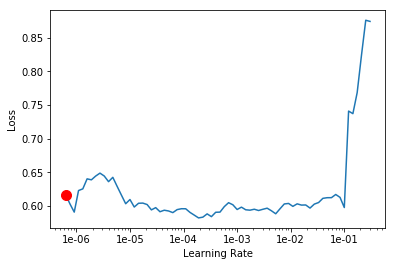

In [51]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [52]:
# training using default learning rate from CheXpert paper
learn.fit(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.599487,0.591230,0.699483,0.624731,05:28
1,0.598795,0.589672,0.699483,0.627358,05:31
2,0.584177,0.590118,0.699483,0.628631,05:37
3,0.585264,0.588905,0.699258,0.630302,05:34
4,0.601263,0.592343,0.699033,0.628025,05:35


In [53]:
learn.save('atelectasis-stage-3-dn121')

In [54]:
# fine tune model further
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


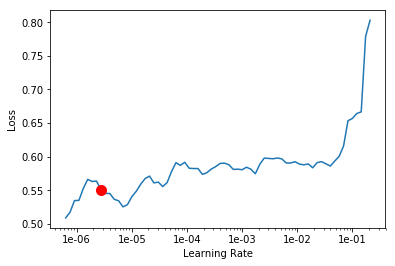

In [55]:
learn.lr_find()
learn.recorder.plot(suggestion=True)